# Qiskit Aer: Pulse simulation using a model from a backend

## Introduction

This notebook shows how to use the Aer pulse simulator, which simulates an OpenPulse `Schedule` on a quantum system at the Hamiltonian level.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root

from qiskit import IBMQ
import qiskit
from qiskit.visualization.bloch import Bloch

# for constructing and specifying pulse experiments
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

# system model object
from qiskit.providers.aer.openpulse.pulse_system_model import PulseSystemModel

# function for construct transmon device models
from qiskit.providers.aer.openpulse.transmon_model_generators import transmon_system_model

# Generating `PulseSystemModel` objects from backends

Alternatively, one may wish to model from an IBM backend. In this case, it is possible to construct one from the backend. The `ibmq_armonk` backend is a single qubit, pulse-enabled device.

In [13]:
provider = IBMQ.load_account()
provider.backends()
armonk_backend = provider.get_backend('ibmq_armonk')

We can construct a model directly from the backend using the `.from_backend` constructor.

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:166: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:356: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


**Note: the above is problematic, as the numbers for the hamiltonian in the backend don't necessarily even have values, e.g. the drive strength in the armonk backend is set to $0$, presumably as there is no well known 'reasonable' number to put in. Furthermore, the units of the qubit frequency are in $rad \times$ GHz still, so are inconsistent with the Hz convention.**

The easiest way around this might be to re-introduce the 'set variable' method back into `HamiltonianModel`.

# Running a pulse schedule on the simulator

First, construct a list of pulse experiments in `Schedule` objects. 

Note: This is taken directly from
https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/1a_calibrating_a_qubit.ipynb
One option is to not run it on the device here at all, but to just reference that tutorial. On the other hand, if that tutorial changes it could mess things up here.

In [4]:
defaults = armonk_backend.defaults()
config = armonk_backend.configuration()

circ_inst_map = defaults.circuit_instruction_map

measure = circ_inst_map.get('measure', qubits=config.meas_map[0])

# qubit to use for experiment
qubit = 0

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 1.0, exps)
drive_samples = 2048
drive_sigma = 256

# scaling factor for data returned by backend
# note: You may have to adjust this for the backend you use
scale_factor=1e-10

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(pulse.DriveChannel(qubit))
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)
    
rabi_qobj = assemble(schedules, armonk_backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     shots=shots)

Run the job

In [5]:
job = armonk_backend.run(rabi_qobj)

In [9]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [7]:
rabi_result = job.result(timeout=3600)

Pi Amplitude 0.326922


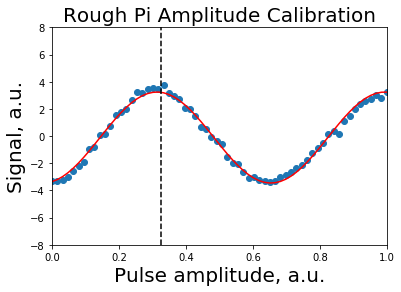

In [8]:
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = rabi_result.get_memory(i)[qubit]*scale_factor
    
    
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)    

rabi_amp_data = get_amplitude(qubit_rabi_data)

fit_func = lambda x,A,B,Omega,phi: (A*np.cos(2*np.pi*x/Omega+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [7.0,0.0,1.0,0.3])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi
#pi_amp = (fitparams[3])*fitparams[2]/2/np.pi

plt.scatter(drive_amps, rabi_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(-8, 8)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

## Run it on the simulator

In [89]:
pi_amp = 0.326922

# Hack the backend configuration to contain numbers corresponding to this fitted pi amp 
dt = getattr(armonk_backend.configuration(), 'dt')
sample_array = pulse_lib.gaussian(duration=drive_samples, amp=1, sigma=drive_sigma).samples
A = sum(sample_array*dt)
omegad0 = np.real(np.pi/(pi_amp*A*2))

getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = getattr(armonk_backend.defaults(), 'qubit_freq_est')[0]

In [90]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

In [91]:
# Get pulse simulator backend
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

In [92]:
qubit_lo_freq = armonk_model.hamiltonian.get_qubit_lo_from_drift()

rabi_qobj_sim = assemble(schedules, 
                         backend=backend_sim, 
                         qubit_lo_freq=qubit_lo_freq,
                         meas_level=1, 
                         meas_return='avg', 
                         shots=shots)

In [93]:
sim_result = backend_sim.run(rabi_qobj_sim, armonk_model).result()
#MeasLevel.KERNELED

Pi Amplitude 0.326922


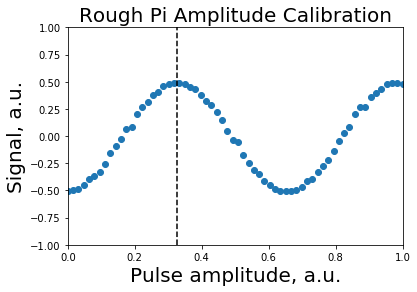

In [94]:
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = sim_result.get_memory(i)[qubit]#*scale_factor
    
    
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)    

rabi_amp_data = get_amplitude(qubit_rabi_data)


plt.scatter(drive_amps, rabi_amp_data)
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

In [95]:
# Function for extracting qubit populations from the memory
def qubit_populations_from_memory(sim_results):
    pop_data_Q0 = []

    for exp_idx in range(exps):
        exp_mem = sim_results.get_memory(exp_idx)
        pop_data_Q0.append(np.real(exp_mem[0]))
    
    return pop_data_Q0



# Function for plotting the data
def rabi_plot(sim_results):
    
    pop_data = qubit_populations_from_memory(sim_results)
    
    # fit the data
    #fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
    #fitparams, conv = curve_fit(fit_func, drive_amps, pop_data[qubit_idx], [0.5,0.5,0.6,1.5])
    
    #get the pi amplitude by finding the point at which the rabi oscillations achieve the max value 
    #pi_amp = root(lambda x: fit_func(x, *fitparams) - 1, x0 = 0.5).x[0]
    
    # Plot the data
    plt.plot(drive_amps, pop_data, label='Q0')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('Rabi on Q0', fontsize=20)
    plt.grid(True)

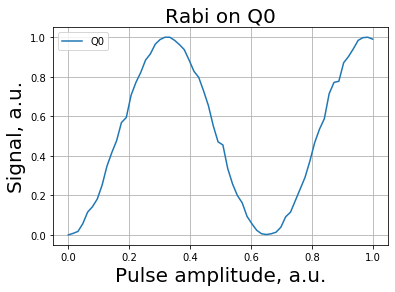

In [96]:
rabi_plot(sim_result)

### sum(rabi_pulse.samples)*getattr(config,'dt')/(2*np.pi)

In [ ]:
getattr(config,'dt')

In [ ]:
dt

In [ ]:
drive_strengths

In [ ]:
test= np.zeros([3, 3])
test[0:2,0:2] = np.array([[0,1],[1,0]])

In [ ]:
test

In [ ]:
bloch_vecs